In [3]:
using MPSTime
using Plots
using JLD2
using Plots.PlotMeasures
using LinearAlgebra
using Base.Threads
# using ITensorMPS
using ProgressMeter
#using ColorSchemes
# include("../../LogLoss/RealRealHighDimension.jl")
# include("../../Interpolation/imputation.jl");

In [4]:
mps_80_f = jldopen("ipd_d12_chi80v2.jld2");
mps_80 = read(mps_80_f, "mps")
mps_80_opts = read(mps_80_f, "opts")
mps_80_Xtrain = read(mps_80_f, "X_train")
mps_80_Xtest = read(mps_80_f, "X_test")
close(mps_80_f)

X_train, norms = transform_train_data(mps_80_Xtrain; opts=mps_80_opts);
X_test, _ = transform_test_data(mps_80_Xtest, norms; opts=mps_80_opts);

┌ Warning: type Main.Options does not exist in workspace; reconstructing
└ @ JLD2 /Users/jmoo2880/.julia/packages/JLD2/OP0XX/src/data/reconstructing_datatypes.jl:622
┌ Warning: type Main.BBOpt does not exist in workspace; reconstructing
└ @ JLD2 /Users/jmoo2880/.julia/packages/JLD2/OP0XX/src/data/reconstructing_datatypes.jl:622
┌ Warning: type Main.Loss_Grad_KLD does not exist in workspace; reconstructing
└ @ JLD2 /Users/jmoo2880/.julia/packages/JLD2/OP0XX/src/data/reconstructing_datatypes.jl:489
┌ Warning: type Main.Basis does not exist in workspace; reconstructing
└ @ JLD2 /Users/jmoo2880/.julia/packages/JLD2/OP0XX/src/data/reconstructing_datatypes.jl:622
┌ Warning: type Main.#legendre_encode_no_norm does not exist in workspace; reconstructing
└ @ JLD2 /Users/jmoo2880/.julia/packages/JLD2/OP0XX/src/data/reconstructing_datatypes.jl:489


UndefVarError: UndefVarError: `transform_train_data` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [215]:
# get the mean and variance
X_train_mean = mean(X_train, dims=1)[1, :]
X_train_std = std(X_train, dims=1)[1, :]

24-element Vector{Float64}:
 0.27791969796799126
 0.21494742497060007
 0.15965145370979714
 0.13553690382868677
 0.11700056262894434
 0.10112705513593068
 0.15572773356968497
 0.2062575568492355
 0.2831865780464314
 0.26051003947563084
 ⋮
 0.22641206158441818
 0.24308040722130303
 0.24245556092318762
 0.2776310997052955
 0.2881952403292616
 0.3106161891209877
 0.32125605895202697
 0.2902685041167557
 0.2758932675608815

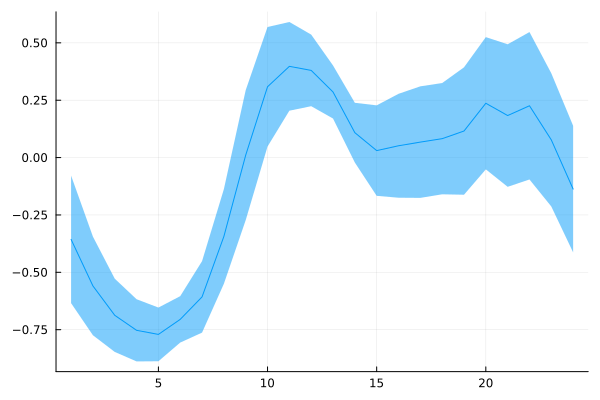

In [216]:
plot(X_train_mean, ribbon=X_train_std, label="")

In [217]:
function one_site_rdm(mps::MPS, A::Int; verify_rdm::Bool=false)
    psi = deepcopy(mps)
    sites = siteinds(psi)
    orthogonalize!(psi, A)
    psidag = dag(psi)
    rho = matrix(prime(psi[A], sites[A]) * psidag[A])
    # check rho is positive semidefinite
    vals, vecs = eigen(rho)
    neg_eigs = findall(x -> x .< 0, vals)
    # check the negative eigenvalues are within numerical precision 
    if !isempty(neg_eigs)
        # set dynamic tolerance based on machine eps, the scale of the max eigenval and the size of the matrix
        tol = eps() * maximum(abs.(vals)) * size(rho, 1)
        neg_eigs_tol = findall(x -> x < -tol, vals) # eigenvals exceeding tolerance
        neg_eigs_minor = findall(x -> (x < 0) && (x >= -tol), vals) # eigenvalues within tolerance
        if !isempty(neg_eigs_tol) # BAD NEWS, throw error and exit
            @error "RDM for site $A has $(length(neg_eigs_tol)) eigenvalue(s) below tolerance ($tol): $(vals[neg_eigs_tol])"
        end
        if !isempty(neg_eigs_minor)
            # clamp insignificant negative eigenvalues
            @info "Clamping $(length(neg_eigs_minor)) negative eigenvalue(s) within tolerance for site $A RDM: $(vals[neg_eigs_minor])"
            #clamp_val = eps() * maximum(vals) * size(rho, 1)
            vals_clamped = clamp.(vals, 1e-16, Inf)
            # reconstruct the corrected RDM with clamped eigenvalues
            rho_corrected = vecs * Diagonal(vals_clamped) * (vecs)'
            # assess norm to get reconstruction error
            delta_rho = rho - rho_corrected
            rho_delta_norm = norm(delta_rho, 2)
            @info "Frobenius norm of the difference after clamping: $rho_delta_norm"
            # verify trace preservation
            tr_diff = abs(tr(rho) - tr(rho_corrected))
            if tr_diff > eps() * size(rho, 1)
                @error "Trace is not preserved in corrected RDM. Trace diff: $(tr_diff)"
            end
            rho = rho_corrected
        end
    end
    if verify_rdm
    # check rdm properties
        trace_rho = tr(rho)
        if !isapprox(tr(rho), 1)
            @warn "RDM at site $A tr(ρ) != 1"
        end
        # verify that rho is hermitian
        conj_diff = norm(rho - rho', 2)
        if conj_diff > eps() * size(rho, 1)
            @warn "ρ at site $A is not hermitian"
        end
    end

    return rho
end

one_site_rdm (generic function with 1 method)

In [218]:
function compute_see(mps::MPS)
    entropy_vals = zeros(length(mps))
    for i in 1:length(mps)
        # get the rdm at the site of interest
        rho = one_site_rdm(mps, i)
        eigs, _ = eigen(rho)
        eigs = max.(eigs, 0.0)
        s = -sum(eigs .* log.(eigs .+ eps()))
        entropy_vals[i] = s
    end
    return entropy_vals
end

compute_see (generic function with 1 method)

In [219]:
function measure_mps(mps::MPS, opts, xval::Float64, site::Int)
    # check xval in range
    if !(-1 ≤ xval ≤ 1)
        error("x value must be in encoding domain [-1, 1]")
    end
    # check site exists in mps
    if !(1 ≤ site ≤ length(mps))
        error("Site must exist in the MPS")
    end
    psi = deepcopy(mps)
    total_num_sites = length(psi)
    s = siteinds(psi)
    known_state_as_ITensor = itensor(get_state(xval, opts), s[site])
    site_loc = findsite(psi, s[site])
    A = psi[site_loc] # extract the site to measure from the MPS 
    Am = A * dag(known_state_as_ITensor)
    if site_loc == total_num_sites
        A_new = psi[(site_loc-1)] * Am # absorb into previous site
    else
        A_new = psi[(site_loc+1)] * Am
    end
    
    normalize!(A_new)
    psi[site_loc] = ITensor(1) # replace old site with Identity
    if site_loc == total_num_sites
        psi[site_loc-1] = A_new
    else
        psi[site_loc + 1] = A_new
    end
    # collapse the MPS to the remaining unmeasured sites
    mps_el = [tens for tens in psi if ndims(tens) > 0]
    mps_measured = MPS(mps_el)
    normalize!(mps_measured)
    return mps_measured
end

measure_mps (generic function with 1 method)

In [220]:
function measure_mps_with_ts_sample(mps::MPS, ts::Vector{<:Real}, opts::Options, measure_sites::Vector)
    # measure the mps with values from an actual (normalised) time series
    # check that the time series is in the encoding domain
    if !all(-1 .≤ ts .≤ 1)
        error("Time series must be normalised to the interval [-1, 1].")
    end
    psi = deepcopy(mps)
    total_num_sites = length(psi) 
    sites = siteinds(psi)
    encoded_ts = MPS([ITensor(opts.encoding.encode(ts[i], opts.d), sites[i]) for i in 1:length(ts)]) # encode all values, only use measure_sites
    # loop through mps and measure sites of interest
    last_impute_idx = 0
    for i in 1:total_num_sites
        if i in measure_sites
            site_loc = findsite(psi, sites[i]) # get the site of interest
            A = psi[site_loc] # extract the site to measure from the MPS 
            known_state_as_ITensor = encoded_ts[i]
            Am = A * dag(known_state_as_ITensor)
            if site_loc == total_num_sites
                A_new = psi[last_impute_idx] * Am # will IndexError if there are no sites to impute
            else
                A_new = psi[(site_loc+1)] * Am
            end
            normalize!(A_new)
            psi[site_loc] = ITensor(1)
            if site_loc == total_num_sites
                psi[last_impute_idx] = A_new 
            else
                psi[site_loc + 1] = A_new
            end
            #println("Measured site $i")
        else
            last_impute_idx = i
        end
    end
    # collapse the MPS to the remaining unmeasured sites
    mps_el = [tens for tens in psi if ndims(tens) > 0]
    mps_measured = MPS(mps_el)
    normalize!(mps_measured)

    return mps_measured
end

measure_mps_with_ts_sample (generic function with 1 method)

# SEE Spectrum

In [221]:
see_spectrum = compute_see(mps_80)

┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 1 RDM: [-8.374337624253465e-18]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 7.735309524870744e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:29
┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 4 RDM: [-4.538132438922811e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 8.776145056154684e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl

24-element Vector{Float64}:
 1.362577320882303
 1.2538668894979415
 1.0243015496180496
 0.8520427266969688
 0.8402978482432092
 0.7222540861597094
 1.1737287328656967
 1.3325767193670417
 1.2849627443819833
 1.2416698491775149
 ⋮
 1.2542099586609283
 1.3047944595973817
 1.3979233014430288
 1.4760809481445152
 1.5394938818144064
 1.6819497422560472
 1.6027316497872022
 1.3398096596982307
 1.2869015436906293

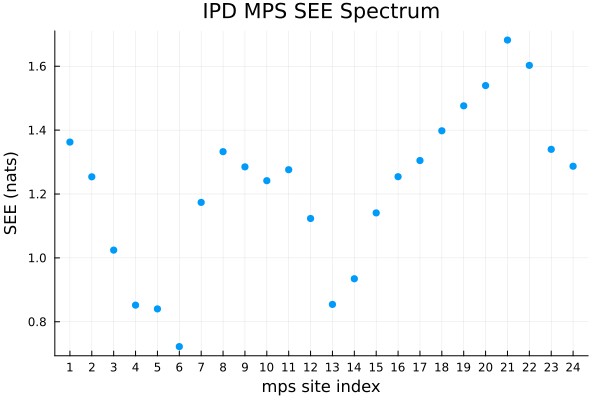

In [222]:
scatter(collect(1:24), see_spectrum, xticks=1:1:24, label="", xlabel="mps site index", ylabel="SEE (nats)", msw=0,
    title="IPD MPS SEE Spectrum")

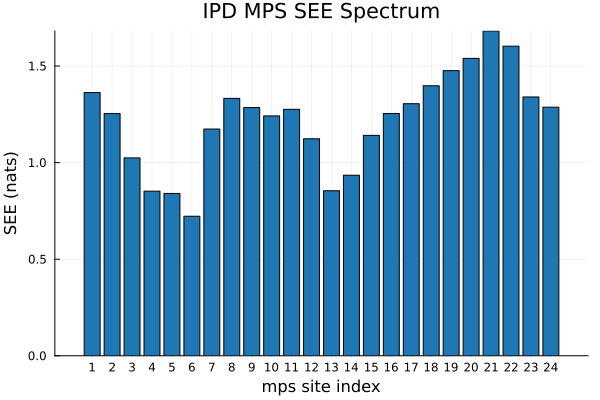

In [233]:
bar(collect(1:24), see_spectrum, xticks=1:1:24, label="", xlabel="mps site index", ylabel="SEE (nats)", msw=0,
    title="IPD MPS SEE Spectrum", c=palette(:tab10)[1])
#savefig("ipd_see_spec_barplot.svg")

In [14]:
see_before = compute_see(mps_80);
sum_before = sum(see_before);

┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 1 RDM: [-8.374337624253465e-18]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 7.735309524870744e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:33
┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 4 RDM: [-4.538132438922811e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 8.776145056154684e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl

In [29]:
measure_sites = []
sample_idx = 123
sums_seq_measure = zeros(23)
for i in 1:20
    push!(measure_sites, i) # add next site to measure
    println("Measuring sites: $measure_sites")
    see_after = compute_see(measure_mps_with_ts_sample(mps_80, X_test[sample_idx, :], mps_80_opts, measure_sites))
    sum_see_after = sum(see_after)
    sums_seq_measure[i] = sum_see_after
end

Measuring sites: Any[1]
Measured site 1


┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 3 RDM: [-2.5732988928925467e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 1.3450686960373527e-15
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:28
┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 4 RDM: [-1.895581861747184e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 7.270875138718822e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/

Measuring sites: Any[1, 2]
Measured site 1
Measured site 2


┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 23 RDM: [-4.3227942502821055e-18]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 1.4045839542076554e-15
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:28
┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 1 RDM: [-5.530895345784738e-18]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 5.221695958674472e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy

Measuring sites: Any[1, 2, 3]
Measured site 1
Measured site 2
Measured site 3


┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 22 RDM: [-5.081573045309753e-18]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 8.673141740902079e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:28
┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 2 RDM: [-1.613539012559507e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 9.332868979367692e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/j

Measuring sites: Any[1, 2, 3, 4]
Measured site 1
Measured site 2
Measured site 3
Measured site 4


┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 1 RDM: [-5.034630280500408e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 3.7442888670327603e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:28
┌ Info: Clamping 2 negative eigenvalue(s) within tolerance for site 2 RDM: [-7.803632836778126e-17, -3.445562013255819e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 9.456017963500336e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmark

Measuring sites: Any[1, 2, 3, 4, 5]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5


┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 18 RDM: [-6.364274558829133e-18]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 7.215486584494961e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:28
┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 19 RDM: [-5.1677792155662695e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 1.0880236255749003e-15
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entrop

Measuring sites: Any[1, 2, 3, 4, 5, 6]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6


┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 19 RDM: [-2.0254358415621276e-18]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 6.926953340492216e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:28


Measuring sites: Any[1, 2, 3, 4, 5, 6, 7]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7


┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 18 RDM: [-1.4800616671342537e-18]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 6.124796930819841e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:28


Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8


┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 14 RDM: [-2.1304947386701223e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 6.799577187807675e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:28


Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10


┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 1 RDM: [-2.1617526788175056e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 6.212121294689819e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:28
┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 6 RDM: [-4.4905671519121773e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 1.2657176580455133e-15
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy

Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11


┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 4 RDM: [-3.193853348481299e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 1.7453923938847052e-15
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:28
┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 7 RDM: [-2.7421670811707733e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 1.14184800838217e-15
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/j

Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12


┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 10 RDM: [-2.987416258629469e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 9.560432542406493e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:28
┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 11 RDM: [-4.301407546748414e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 9.165310936742784e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/

Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13


┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 6 RDM: [-4.819123596475349e-18]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 7.617125461697651e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:28
┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 9 RDM: [-6.33990072033734e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 1.1117534054213144e-15
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl

Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14


┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 8 RDM: [-3.137399643178057e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 9.940707212627591e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:28
┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 9 RDM: [-4.172700452681803e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 8.634076454434882e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl

Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15


┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 9 RDM: [-1.6590361926689912e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 1.8081291836990897e-15
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:28
┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 10 RDM: [-7.162654073187541e-20]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 1.4160958112854085e-15
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entrop

Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16


┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 5 RDM: [-6.963966324341733e-18]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 1.2201570208552771e-15
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:28
┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 7 RDM: [-3.951201820004829e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 1.2693846860456472e-15
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/

Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17


┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 4 RDM: [-6.661127573471505e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 1.1078729007334046e-15
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:28
┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 5 RDM: [-2.109113889783055e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 1.6019539668520188e-15
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/

Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site

┌ Info: Clamping 1 negative eigenvalue(s) within tolerance for site 5 RDM: [-1.543080953355028e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 7.819663613689368e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:28
┌ Info: Clamping 2 negative eigenvalue(s) within tolerance for site 6 RDM: [-3.9909161003796346e-17, -1.3908913440974253e-17]
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmarks/entanglement_entropy/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:21
┌ Info: Frobenius norm of the difference after clamping: 8.552695632736255e-16
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/FinalBenchmar

In [6]:
function osrdm(mps::MPS, A::Int)
    """Get the one-site reduced density matrix"""
    psi = deepcopy(mps)
    sites = siteinds(psi)
    orthogonalize!(psi, A)
    psidag = dag(psi)
    rho = matrix(prime(psi[A], sites[A]) * psidag[A])
    return rho
end

osrdm (generic function with 1 method)

In [7]:
function see(osrdm::Matrix; tol::Union{Symbol, Float64}=eps())
    """Get the single site entanglement entropy"""
    eig_orig, _ = eigen(osrdm)
    if tol == :adaptive
        # use adaptive tolerance which scales according to size of matrix and max eig
        tol = eps() * size(osrdm, 1) * maximum(eig_orig)
        @info "Using adaptive tolerance: $tol"
    end
    # clamp small eigenvalues (positive or negative to zero), also handle small complex
    # (if exists), set imag part to zero if less than tol
    eig_c = Complex{Float64}[abs(imag(eig)) < tol ? real(eig) : eig for eig in eig_orig]
    eig_clamped = [abs(eig) < tol ? 0.0 : eig for eig in eig_c] # clamp small values to zero
    entropy = -sum(eig == 0 ? 0 : real(eig) * log(real(eig)) for eig in eig_clamped)
    return entropy
end

see (generic function with 1 method)

In [245]:
measured = measure_mps_with_ts_sample(mps_80, X_test[1, :], mps_80_opts, collect(1:15))

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15


MPS
[1] ((dim=12|id=252|"Site,n=16"), (dim=67|id=61|"Link,l=16"))
[2] ((dim=12|id=597|"Site,n=17"), (dim=67|id=61|"Link,l=16"), (dim=67|id=104|"Link,l=17"))
[3] ((dim=12|id=93|"Site,n=18"), (dim=67|id=104|"Link,l=17"), (dim=67|id=614|"Link,l=18"))
[4] ((dim=12|id=940|"Site,n=19"), (dim=67|id=614|"Link,l=18"), (dim=67|id=367|"Link,l=19"))
[5] ((dim=12|id=631|"Site,n=20"), (dim=67|id=367|"Link,l=19"), (dim=67|id=832|"Link,l=20"))
[6] ((dim=12|id=759|"Site,n=21"), (dim=67|id=832|"Link,l=20"), (dim=67|id=192|"Link,l=21"))
[7] ((dim=12|id=666|"Site,n=22"), (dim=67|id=192|"Link,l=21"), (dim=39|id=696|"Link,l=22"))
[8] ((dim=12|id=362|"Site,n=23"), (dim=39|id=696|"Link,l=22"), (dim=11|id=953|"Link,l=23"))
[9] ((dim=12|id=746|"Site,n=24"), (dim=11|id=953|"Link,l=23"))


In [19]:
mps_start = deepcopy(mps_80);
mps_start_opts = deepcopy(mps_80_opts)
see_init = [see(osrdm(mps_start, i)) for i in 1:24];
measure_sites = []
ts_instance = 9
measurement_mat = fill(NaN, length(mps_start)+1, length(mps_start))
for site in 0:(length(mps_start)-1)
    if site !== 0
        push!(measure_sites, site)
    end
    println("Measuring sites: $measure_sites")
    mps_measured = measure_mps_with_ts_sample(mps_start, X_test[ts_instance, :], mps_start_opts, measure_sites)
    remaining_site_entropies = [see(osrdm(mps_measured, i); tol=1e-15) for i in 1:length(mps_measured)]
    measurement_mat[site+1, site+1:end] = remaining_site_entropies
end

Measuring sites: Any[]
Measuring sites: Any[1]
Measuring sites: Any[1, 2]
Measuring sites: Any[1, 2, 3]
Measuring sites: Any[1, 2, 3, 4]
Measuring sites: Any[1, 2, 3, 4, 5]
Measuring sites: Any[1, 2, 3, 4, 5, 6]
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7]
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8]
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9]
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7,

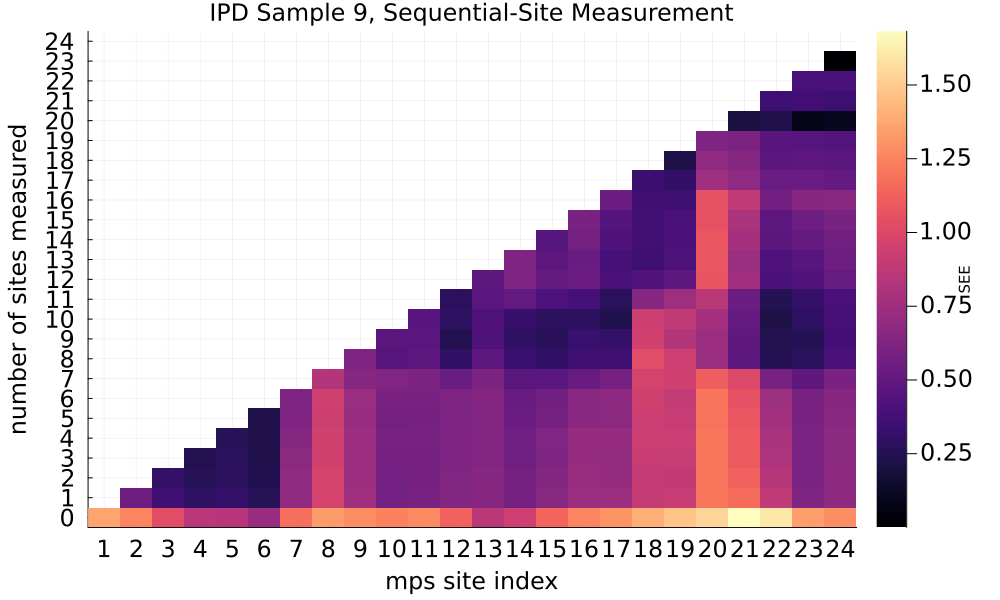

In [239]:
fstyle = font("sans-serif", 16)
heatmap(collect(1:24), collect(0:24), measurement_mat, 
    xticks=1:24, yticks=0:24, xlabel="mps site index", ylabel="number of sites measured",
    title="IPD Sample $ts_instance, Sequential-Site Measurement",
    colorbar_title="SEE", c=:magma, left_margin=5mm, 
    bottom_margin=5mm, right_margin=5mm, 
    xtickfont=fstyle, 
    titlefont=fstyle,
    guidefont=fstyle,
    ytickfont=fstyle, size=(1000, 600))

Try and measure site 21

In [344]:
sum(see_init)/length(see_init)

1.220893858596764

In [310]:
mps_measured = measure_mps_with_ts_sample(mps_start, X_test[1, :], mps_start_opts, [21])
remaining_site_entropies = [see(osrdm(mps_measured, i)) for i in 1:length(mps_measured)]

Measured site 21


23-element Vector{Float64}:
 0.7977224157634211
 0.7832485978076331
 0.6354171189356135
 0.5410637890180809
 0.5505073350889497
 0.5013595751923623
 0.5793029018377556
 1.0150657402381023
 0.9573732420775319
 0.7676969990730953
 ⋮
 0.7379755604935021
 0.7815495142051557
 0.8949878380511176
 1.1601558065658952
 1.194614842801409
 1.1369519736799636
 0.9323839759370907
 0.790503412082998
 0.8890513037938957

In [13]:
mps_start = deepcopy(mps_80);
mps_start_opts = deepcopy(mps_80_opts)
measurement_mat_all_test = fill(NaN, size(X_test, 1), length(mps_start)+1, length(mps_start)) # first dimension is test instance

for ts_instance in 1:size(X_test, 1)
    println("Evaluating instance $ts_instance")
    measure_sites = [] # store the indices for the sites to measure, gradually build up
    measurement_mat = fill(NaN, length(mps_start)+1, length(mps_start))
    for site in 0:(length(mps_start)-1)
        if site !== 0 # get initial ee for unmeasured mps as well
            push!(measure_sites, site)
        end
        #println("Measuring sites: $measure_sites")
        mps_measured = measure_mps_with_ts_sample(mps_start, X_test[ts_instance, :], mps_start_opts, measure_sites)
        remaining_site_entropies = [see(osrdm(mps_measured, i); tol=1e-15) for i in 1:length(mps_measured)]
        measurement_mat[(site+1), site+1:end] = remaining_site_entropies
    end
    measurement_mat_all_test[ts_instance, :, :] = measurement_mat
end

Evaluating instance 1
Evaluating instance 2
Evaluating instance 3
Evaluating instance 4
Evaluating instance 5
Evaluating instance 6
Evaluating instance 7
Evaluating instance 8
Evaluating instance 9
Evaluating instance 10
Evaluating instance 11
Evaluating instance 12
Evaluating instance 13
Evaluating instance 14
Evaluating instance 15
Evaluating instance 16
Evaluating instance 17
Evaluating instance 18
Evaluating instance 19
Evaluating instance 20
Evaluating instance 21
Evaluating instance 22
Evaluating instance 23
Evaluating instance 24
Evaluating instance 25
Evaluating instance 26
Evaluating instance 27
Evaluating instance 28
Evaluating instance 29
Evaluating instance 30
Evaluating instance 31
Evaluating instance 32
Evaluating instance 33
Evaluating instance 34
Evaluating instance 35
Evaluating instance 36
Evaluating instance 37
Evaluating instance 38
Evaluating instance 39
Evaluating instance 40
Evaluating instance 41
Evaluating instance 42
Evaluating instance 43
Evaluating instance 

In [ ]:
# JLD2.@save "ipd_seq_mat.jld2" measurement_mat_all_test

In [90]:
JLD2.@load "ipd_seq_mat.jld2"

1-element Vector{Symbol}:
 :measurement_mat_all_test

In [94]:
# average over all test instances
test_set_mean_measure_matrix = fill(NaN, length(mps_80)+1, length(mps_80))
test_set_median_measure_matrix = fill(NaN, length(mps_80)+1, length(mps_80))
test_set_std_measure_matrix = fill(NaN, length(mps_80)+1, length(mps_80))
for i in 0:(length(mps_80)+1)
    for j in (i+1):length(mps_80)
        test_set_mean_measure_matrix[i+1, j] = mean(measurement_mat_all_test[:, i+1, j])
        test_set_std_measure_matrix[i+1, j] = std(measurement_mat_all_test[:, i+1, j])
        test_set_median_measure_matrix[i+1, j] = median(measurement_mat_all_test[:, i+1, j])
    end
end

In [198]:
clim_min, clim_max = 0, maximum(filter(!isnan,test_set_mean_measure_matrix))

(0, 1.6819497422560548)

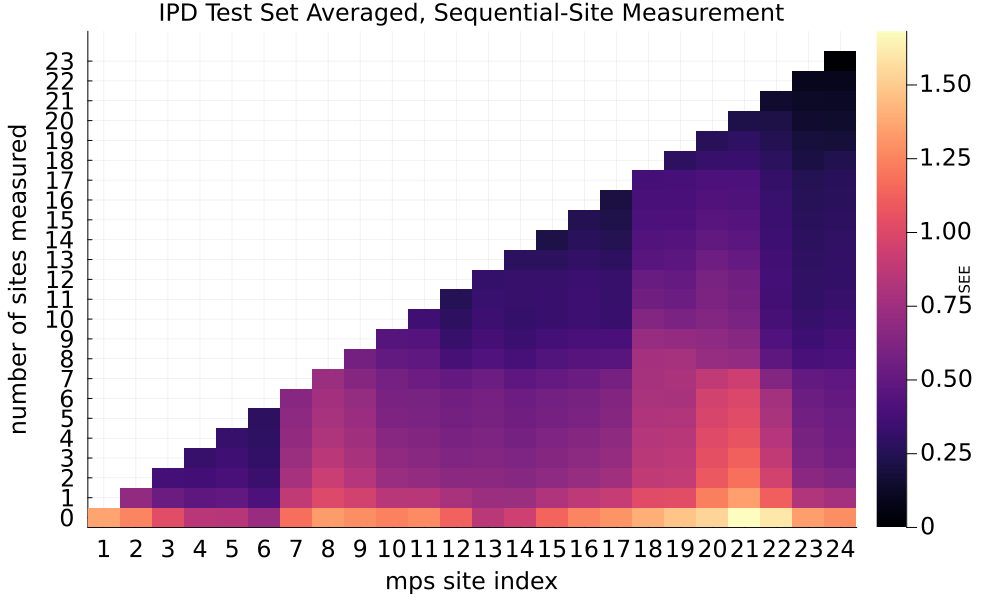

In [201]:
fstyle = font("sans-serif", 16)
heatmap(collect(1:24), collect(0:24), test_set_mean_measure_matrix, xticks=1:24, yticks=0:23, 
xlabel="mps site index", ylabel="number of sites measured",
    title="IPD Test Set Averaged, Sequential-Site Measurement",
    colorbar_title="SEE", c=:magma, clims=(clim_min, clim_max), left_margin=5mm, 
    bottom_margin=5mm, right_margin=5mm, 
    xtickfont=fstyle, 
    titlefont=fstyle,
    guidefont=fstyle,
    ytickfont=fstyle, size=(1000, 600))
#savefig("ipd_sequential_testset_avg_seefinal.svg")

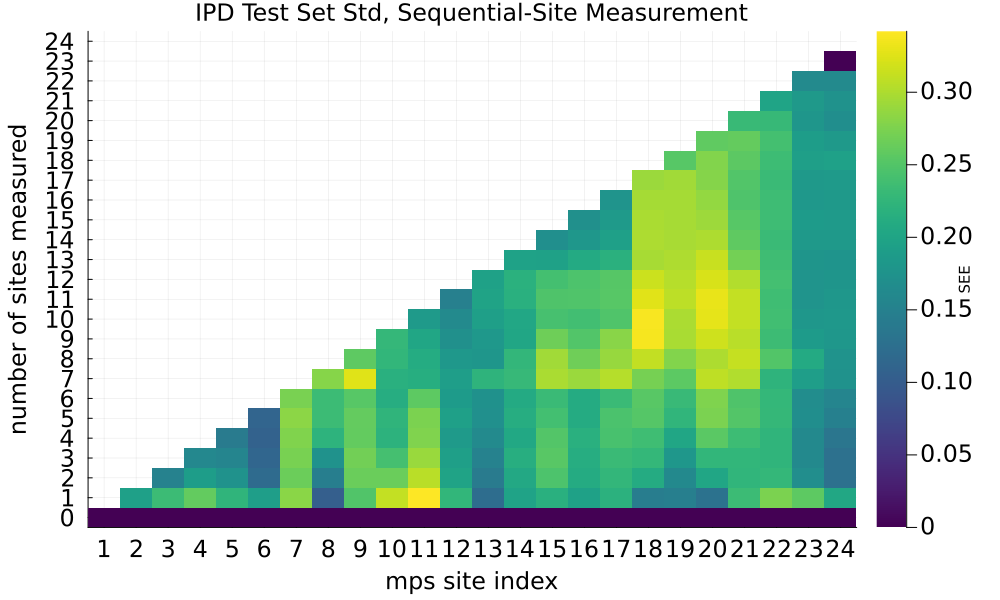

In [96]:
fstyle = font("sans-serif", 16)
heatmap(collect(1:24), collect(0:24), test_set_std_measure_matrix, xticks=1:24, yticks=0:24, 
xlabel="mps site index", ylabel="number of sites measured",
    title="IPD Test Set Std, Sequential-Site Measurement",
    colorbar_title="SEE", c=:viridis, left_margin=5mm, 
    bottom_margin=5mm, right_margin=5mm, 
    xtickfont=fstyle, 
    titlefont=fstyle,
    guidefont=fstyle,
    ytickfont=fstyle, size=(1000, 600))

Looking at slices - how does a given site's SEE change as more sites are measured

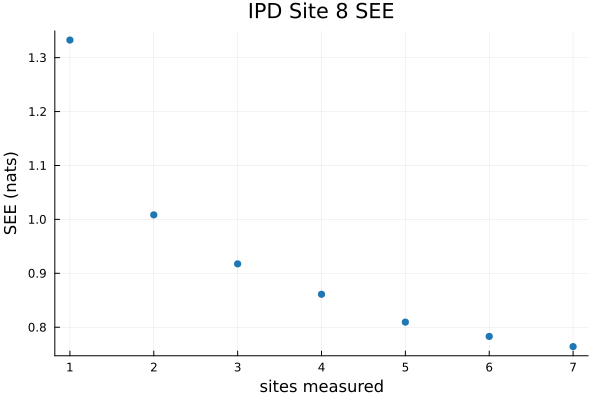

In [97]:
site = 8
scatter(test_set_mean_measure_matrix[1:site-1, site], xticks=1:1:24, msw=0,
    label="", xlabel="sites measured", ylabel="SEE (nats)",
    title="IPD Site $site SEE", c=palette(:tab10)[1])
#savefig("ipd_site24_see.svg")

Sum along rows for residual entropy

In [98]:
sum(test_set_mean_measure_matrix[1, :])

29.301452606322247

Normalised residual entropy in unmeasured sites (average SEE per site) given some number of measured sites

In [149]:
measurement_mat_all_test[5, 24, :]

24-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   3.330669073875469e-16

In [113]:
avg_see_per_measure = [sum(measurement_mat_all_test[1, i, i:end])/length(measurement_mat_all_test[1, i, i:end]) for i in 1:24]

24-element Vector{Float64}:
  1.2208938585967608
  1.0659135922114111
  0.8920626368406542
  0.6242746201256824
  0.6317671638906852
  0.6401130286947486
  0.647012327439577
  0.5272680432792537
  0.4342760405799144
  0.38318014837766423
  ⋮
  0.013116295749932665
  0.011835947302606904
  0.06937640869167598
  0.13210523275737293
  0.33795083360755007
  0.2923280428422631
  0.374251912965859
  0.21800862459850345
 -2.220446049250313e-16

In [124]:
residual_entropy_allsamps = Matrix{Float64}(undef, size(measurement_mat_all_test, 1), 24)
for s in 1:size(measurement_mat_all_test, 1)
    residual_entropy_allsamps[s, :] = [sum(measurement_mat_all_test[s, i, i:end])/length(measurement_mat_all_test[s, i, i:end]) for i in 1:24]
end

In [132]:
mean_res_entr = mean(residual_entropy_allsamps, dims=1)[1, :]
std_res_entr = std(residual_entropy_allsamps, dims=1)[1, :]

24-element Vector{Float64}:
 6.664577310669212e-16
 0.18480300427005003
 0.14534679362164393
 0.1487285536860023
 0.15678659861075533
 0.16988553466554182
 0.17104021691313814
 0.20701690817232432
 0.19901312505051183
 0.19941856099685903
 ⋮
 0.183261997027272
 0.18976413620586896
 0.20255789600219476
 0.2004315206138565
 0.2060098074831186
 0.18689131692431857
 0.17827598531462896
 0.16163918483404366
 1.2601307685950131e-14

mean and std across samples for each number of measured sites

In [210]:
colormap = ColorSchemes.magma
normalised_res_entr = (mean_res_entr .- clim_min) ./ (clim_max - clim_min) # use same colorscale as heatmap
bar_colors = [colormap[x] for x in normalised_res_entr]

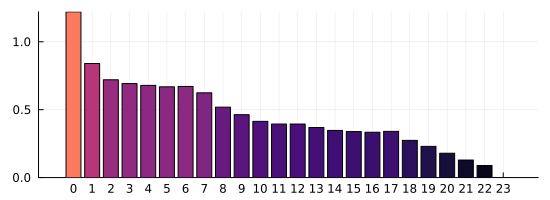

In [214]:
bar(collect(0:23), mean_res_entr, xticks=0:1:23, label="", yticks=0:0.5:1.5,
    size=(550, 200), c=bar_colors)
#savefig("ipd_resid_see_barplot.svg")

---

In [267]:
res_entropy = [sum(test_set_mean_measure_matrix[i, i:end])/length(i:24) for i in 1:24];

In [268]:
res_entropy

24-element Vector{Float64}:
 1.2208938585967604
 0.8400685270086449
 0.7202076454996154
 0.6922586235389212
 0.6789667283376148
 0.6684479860112432
 0.6711753716637767
 0.6240229039269347
 0.518366728109301
 0.46316863957255927
 ⋮
 0.33880864839240843
 0.33396978888270257
 0.33999414735663075
 0.2737738459384414
 0.22956879184755744
 0.1791308535845204
 0.12898617304549748
 0.08874840773503907
 4.9371275462425745e-15

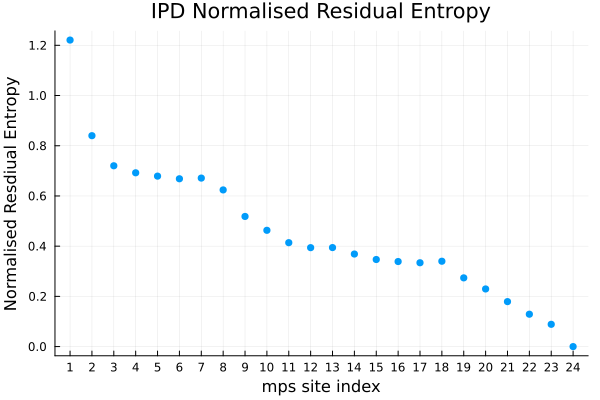

In [276]:
scatter(res_entropy, xlabel="mps site index", ylabel="Normalised Resdiual Entropy",
    label="", title="IPD Normalised Residual Entropy", msw=0, xticks=1:1:24)#
#savefig("ipd_norm_res_entropy.svg")

In [14]:
see_spectrum_ipd = [see(osrdm(mps_80, i)) for i in 1:24]

24-element Vector{Float64}:
 1.3625773208823033
 1.2538668894979441
 1.0243015496180414
 0.8520427266969668
 0.840297848243202
 0.7222540861597102
 1.1737287328656916
 1.3325767193670444
 1.284962744381986
 1.2416698491775175
 ⋮
 1.254209958660931
 1.3047944595973844
 1.3979233014430317
 1.4760809481445178
 1.5394938818144093
 1.6819497422560499
 1.602731649787205
 1.3398096596982334
 1.2869015436906317

In [15]:
cmap = create_colormap(see_spectrum_ipd)

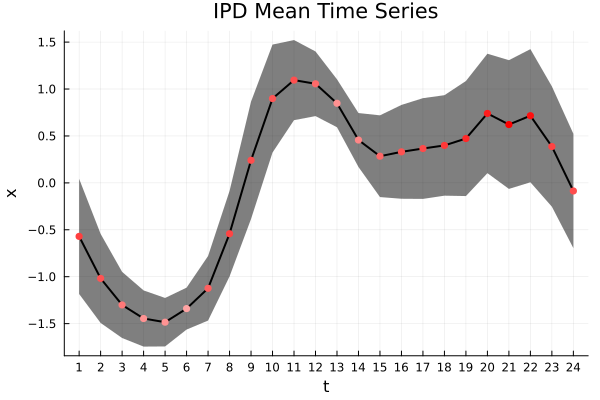

In [16]:
mean_ts = mean(mps_80_Xtrain, dims=1)[1, :]
std_ts = std(mps_80_Xtrain, dims=1)[1, :]
plot(mean_ts, label="", xlabel="t", ylabel="x", title="IPD Mean Time Series",
    xticks=1:1:24, ribbon=std_ts, c=:black, lw=2)
scatter!(mean_ts, msw=0, ms=4, c=cmap, label="")
#savefig("ipd_see_spectrum_overlayed.svg")

----

# ECG200

In [4]:
mps_80_f = jldopen("/Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/ecg_d_12_chi_80.jld2");
ecg_f = jldopen("/Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/Data/ecg200/datasets/ecg200.jld2")
mps_80 = read(mps_80_f, "mps")
mps_80_opts = read(mps_80_f, "opts_safe")
mps_80_Xtrain = read(ecg_f, "X_train")
mps_80_Xtest = read(ecg_f, "X_test")
close(mps_80_f)

X_train, norms = transform_train_data(mps_80_Xtrain; opts=mps_80_opts);
X_test, _ = transform_test_data(mps_80_Xtest, norms; opts=mps_80_opts);

┌ Warning: Test set has a value more than 1% below lower bound after train normalization! lb=-0.05051431347958382
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/LogLoss/utils.jl:253
┌ Warning: Test set has a value more than 1% below lower bound after train normalization! lb=-0.058283139456711236
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/LogLoss/utils.jl:253


5 rescaling operations were performed!


┌ Warning: Test set has a value more than 1% below lower bound after train normalization! lb=-0.04947715552359307
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/LogLoss/utils.jl:253


In [5]:
ecg_see_spectrum = [see(osrdm(mps_80, i)) for i in 1:length(mps_80)]

96-element Vector{Float64}:
 1.1063869095497647
 1.556381634268869
 1.698649187215032
 1.787916692748878
 1.554197316293258
 1.567023706178828
 1.6825124109776062
 1.4889892041010195
 1.3796761369333885
 1.3645202611169598
 ⋮
 0.9093077841083668
 0.9201101833159461
 1.0813561675414713
 1.1736824269258315
 1.220823904747931
 1.2219255403824114
 1.1513273951716232
 1.1763852901944079
 0.8632609837355218

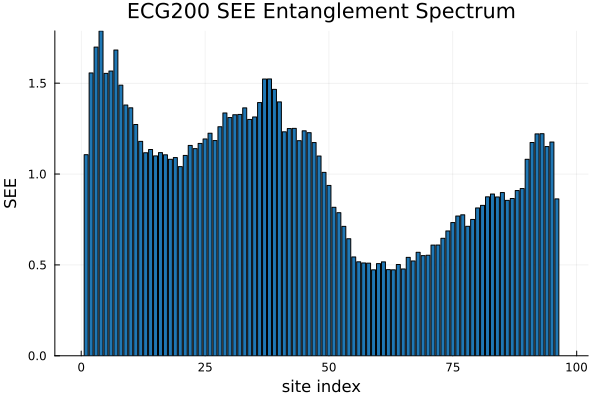

In [6]:
bar(ecg_see_spectrum, label="", xlabel="site index", ylabel="SEE",
    c=palette(:tab10)[1], title="ECG200 SEE Entanglement Spectrum")
#savefig("ecg200_see_spectrum.svg")

In [7]:
ecg_see_spectrum[35:40]

6-element Vector{Float64}:
 1.3140544638057685
 1.3934697842933368
 1.5227601925891334
 1.5233313063750236
 1.465937536292111
 1.3969919019385646

In [21]:
mean_ts = mean(mps_80_Xtrain, dims=1)[1, :]
std_ts = std(mps_80_Xtrain, dims=1)[1, :]

96-element Vector{Float64}:
 0.5935128982505872
 0.9279719819328901
 1.0468800211894889
 1.098753662034098
 0.9547343215125306
 0.9631108612044943
 1.0967122827421285
 0.8776404248424444
 0.7617531971905132
 0.7391851359895361
 ⋮
 0.4340019749182154
 0.4543948842482049
 0.5898787384177827
 0.7721036765405389
 0.8710452248428904
 0.8323122916607146
 0.6655482967807774
 0.619798649957833
 0.41364376515603196

In [52]:
function create_colormap(values::Vector{Float64}, color_start::Colorant=colorant"white", color_end::Colorant=colorant"red")
    # Normalize the values to the range [0, 1]
    min_val = -minimum(values)
    max_val = maximum(values)
    norm_values = (values .- min_val) ./ (max_val - min_val) 
    norm_values .^= 4

    # Create a colormap by interpolating between the start and end colors
    colormap = [color_start * (1 - v) + color_end * v for v in norm_values]


    return colormap
end

create_colormap (generic function with 3 methods)

In [9]:
cmap = create_colormap(ecg_see_spectrum)

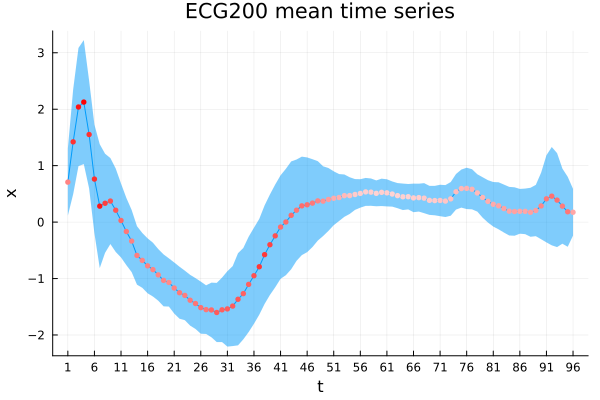

In [24]:
p = plot(mean_ts, ribbon=std_ts, label="")
p = scatter!(mean_ts, msw=0, ms=3, c=cmap, label="", xlabel="t", ylabel="x",
    xticks=1:5:96, title="ECG200 mean time series")
#savefig("ecg200_see_spectrum_overlayed.svg")

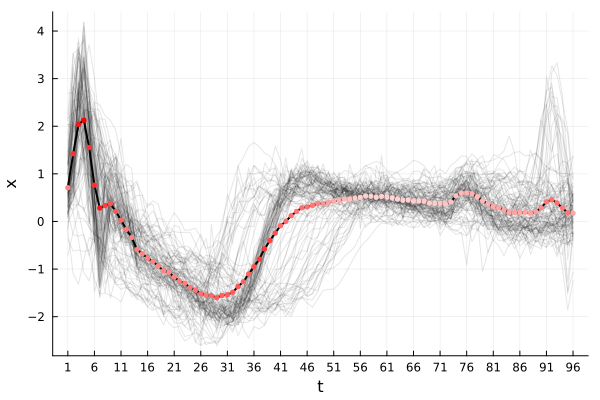

In [25]:
p = plot(mps_80_Xtrain[1, :], label="", c=:black, lw=1,
    xlabel="t", ylabel="x", alpha=0.1, xticks=1:5:96)
for i in 2:100
    p =plot!(mps_80_Xtrain[i, :], lw=1, alpha=0.1, c=:black, label="")
end
p = plot!(mean_ts, lw=2, c=:black, label="")
p = scatter!(mean_ts, msw=0, ms=3, c=cmap, label="")
display(p)

In [ ]:
mps_start = deepcopy(mps_80);
mps_start_opts = deepcopy(mps_80_opts)
measurement_mat_all_test = fill(NaN, size(X_test, 1), length(mps_start)+1, length(mps_start)) # first dimension is test instance

for ts_instance in 1:1
    println("Evaluating instance $ts_instance")
    measure_sites = [] # store the indices for the sites to measure, gradually build up
    measurement_mat = fill(NaN, length(mps_start)+1, length(mps_start))
    for site in 0:(length(mps_start)-1)
        if site !== 0 # get initial ee for unmeasured mps as well
            push!(measure_sites, site)
        end
        println("Measuring sites: $measure_sites")
        mps_measured = measure_mps_with_ts_sample(mps_start, X_test[ts_instance, :], mps_start_opts, measure_sites)
        remaining_site_entropies = [see(osrdm(mps_measured, i); tol=1e-15) for i in 1:length(mps_measured)]
        measurement_mat[(site+1), site+1:end] = remaining_site_entropies
    end
    measurement_mat_all_test[ts_instance, :, :] = measurement_mat
end

Evaluating instance 1
Measuring sites: Any[60, 36, 48, 24, 72]
Measuring sites: Any[60, 36, 48, 24, 72]
Measuring sites: Any[60, 36, 48]
Measuring sites: Any[60, 36, 48, 24, 72, 84]
Measuring sites: Any[60, 36, 48, 24, 72, 84, 12]
Measuring sites: Any[60, 36]
Measuring sites: Any[60, 36, 48, 24, 72, 84, 12]
Measuring sites: Any[60, 36]


In [311]:
# average over all test instances
test_set_mean_measure_matrix = fill(NaN, length(mps_start)+1, length(mps_start))
test_set_median_measure_matrix = fill(NaN, length(mps_start)+1, length(mps_start))
test_set_std_measure_matrix = fill(NaN, length(mps_start)+1, length(mps_start))
for i in 0:(length(mps_start)+1)
    for j in (i+1):length(mps_start)
        test_set_mean_measure_matrix[i+1, j] = mean(measurement_mat_all_test[1:1, i+1, j])
        test_set_std_measure_matrix[i+1, j] = std(measurement_mat_all_test[1:1, i+1, j])
        test_set_median_measure_matrix[i+1, j] = median(measurement_mat_all_test[1:1, i+1, j])
    end
end

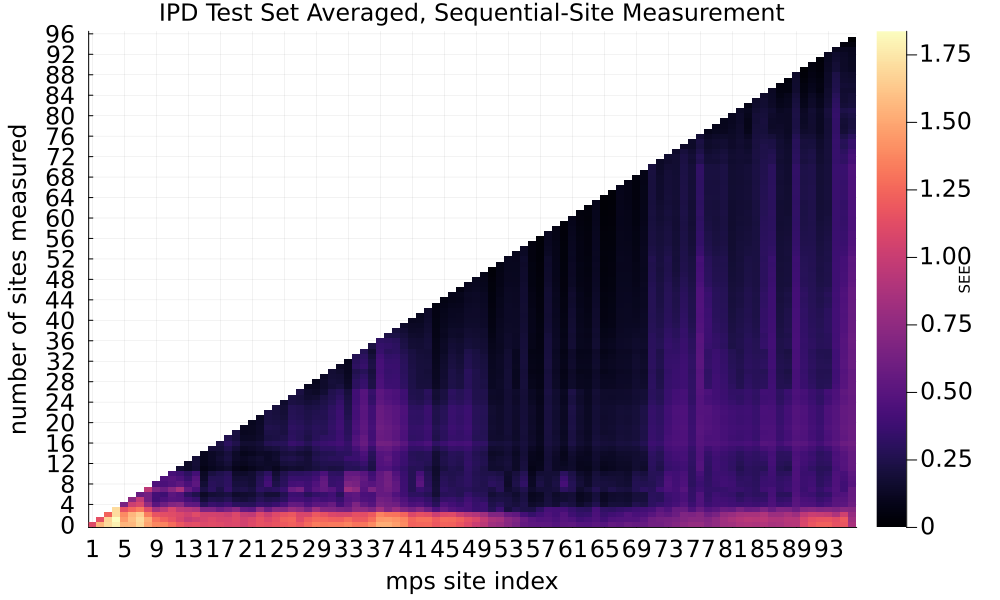

In [313]:
fstyle = font("sans-serif", 16)
heatmap(collect(1:96), collect(0:96), test_set_mean_measure_matrix, xticks=1:4:96, yticks=0:4:96, 
xlabel="mps site index", ylabel="number of sites measured",
    title="IPD Test Set Averaged, Sequential-Site Measurement",
    colorbar_title="SEE", c=:magma, left_margin=5mm, 
    bottom_margin=5mm, right_margin=5mm, 
    xtickfont=fstyle, 
    titlefont=fstyle,
    guidefont=fstyle,
    ytickfont=fstyle, size=(1000, 600))

# NTS, Simple

In [8]:
mps_80_f = jldopen("/Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/nts_simple_mps.jld2");
mps_80 = read(mps_80_f, "mps")
mps_80_opts = read(mps_80_f, "opts")
nts_f = jldopen("/Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/Data/syntheticV2/simple/datasets/eta_01_m_3_tau_20.jld2");
mps_80_Xtrain = read(nts_f, "X_train")
mps_80_Xtest = read(nts_f, "X_test")
close(mps_80_f)
close(nts_f)

X_train, norms = transform_train_data(mps_80_Xtrain; opts=mps_80_opts);
X_test, _ = transform_test_data(mps_80_Xtest, norms; opts=mps_80_opts);

1 rescaling operations were performed!


In [37]:
nts_see_spectrum = [see(osrdm(mps_80, i)) for i in 1:length(mps_80)]

100-element Vector{Float64}:
 1.5687102151633792
 1.5436627160261893
 1.5625458154448104
 1.5310588244401497
 1.5436535458087661
 1.5287574163868614
 1.493487814574409
 1.4864694299629393
 1.490506405156927
 1.458442877000393
 ⋮
 1.5071185441402104
 1.5155898867319966
 1.5453358398533834
 1.5393661086684343
 1.5266713672461294
 1.5611707391641496
 1.5812801720278034
 1.592076848698209
 1.6106203133509096

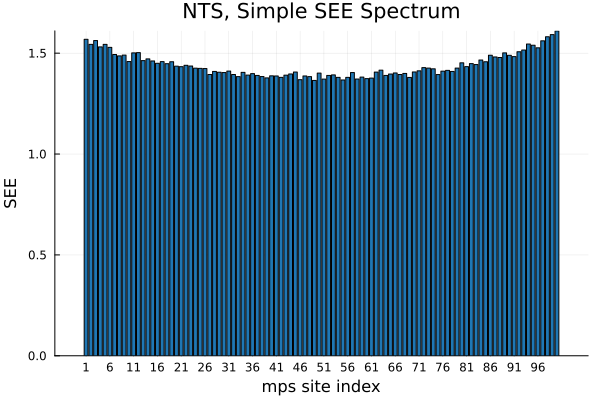

In [61]:
bar(nts_see_spectrum, label="", xlabel="mps site index", xticks=1:5:100,
    ylabel="SEE", title="NTS, Simple SEE Spectrum", c=palette(:tab10)[1])
#savefig("nts_simple_see_spectrum.svg")

In [73]:
cmap = create_colormap(nts_see_spectrum);

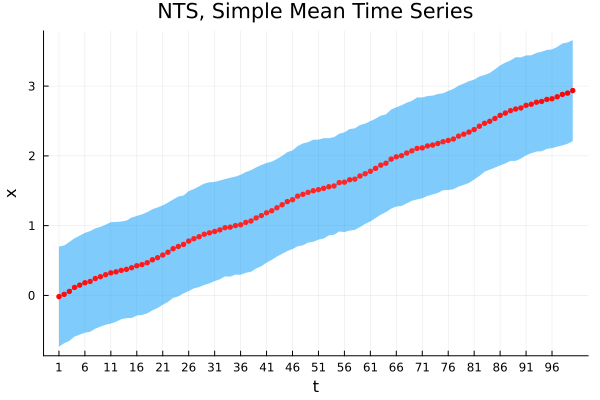

In [80]:
mean_ts = mean(mps_80_Xtrain, dims=1)[1, :]
std_ts = std(mps_80_Xtrain, dims=1)[1, :]
plot(mean_ts, ribbon=std_ts, xlabel="t", ylabel="x", 
    title="NTS, Simple Mean Time Series", label="", xticks=1:5:100)
scatter!(mean_ts, c=cmap, msw=0, ms=3, label="")
#savefig("nts_see_spectrum_overlayed.svg")

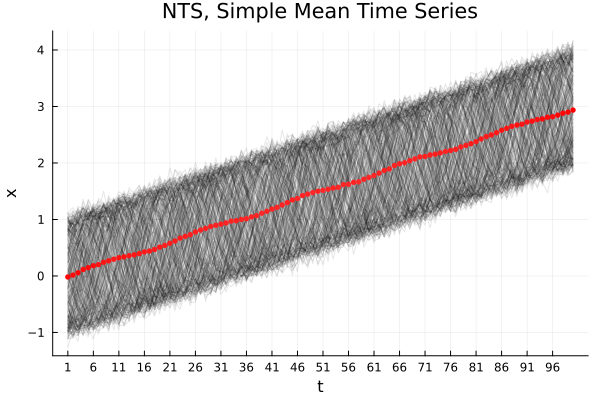

In [92]:
p = plot(mps_80_Xtrain[1, :], lw=1, alpha=0.1, c=:black,
    xlabel="t", ylabel="x", 
    title="NTS, Simple Mean Time Series", label="", xticks=1:5:100)
for i in 2:300
    p = plot!(mps_80_Xtrain[i, :], lw=1, alpha=0.1, c=:black, label="")
end
scatter!(mean_ts, c=cmap, msw=0, ms=3, label="")
display(p)

Just measure site 1

In [29]:
mps_measured1 = measure_mps_with_ts_sample(mps_80, X_test[4, :], mps_80_opts, [1])
mps_measured2 = measure_mps_with_ts_sample(mps_80, X_test[4, :], mps_80_opts, [1, 2])

MPS
[1] ((dim=12|id=494|"Site,n=3"), (dim=80|id=245|"Link,l=3"))
[2] ((dim=12|id=298|"Site,n=4"), (dim=80|id=245|"Link,l=3"), (dim=80|id=513|"Link,l=4"))
[3] ((dim=12|id=602|"Site,n=5"), (dim=80|id=513|"Link,l=4"), (dim=80|id=882|"Link,l=5"))
[4] ((dim=12|id=772|"Site,n=6"), (dim=80|id=882|"Link,l=5"), (dim=80|id=389|"Link,l=6"))
[5] ((dim=12|id=706|"Site,n=7"), (dim=80|id=389|"Link,l=6"), (dim=80|id=725|"Link,l=7"))
[6] ((dim=12|id=803|"Site,n=8"), (dim=80|id=725|"Link,l=7"), (dim=80|id=299|"Link,l=8"))
[7] ((dim=12|id=805|"Site,n=9"), (dim=80|id=299|"Link,l=8"), (dim=80|id=217|"Link,l=9"))
[8] ((dim=12|id=16|"Site,n=10"), (dim=80|id=217|"Link,l=9"), (dim=80|id=122|"Link,l=10"))
[9] ((dim=12|id=617|"Site,n=11"), (dim=80|id=122|"Link,l=10"), (dim=80|id=459|"Link,l=11"))
[10] ((dim=12|id=546|"Site,n=12"), (dim=80|id=459|"Link,l=11"), (dim=80|id=356|"Link,l=12"))
[11] ((dim=12|id=203|"Site,n=13"), (dim=80|id=356|"Link,l=12"), (dim=80|id=523|"Link,l=13"))
[12] ((dim=12|id=116|"Site,n=14")

In [31]:
mps_measured3 = measure_mps_with_ts_sample(mps_80, X_test[4, :], mps_80_opts, [1, 2, 3])
mps_measured4 = measure_mps_with_ts_sample(mps_80, X_test[4, :], mps_80_opts, [1, 2, 3, 4])
mps_measured5 = measure_mps_with_ts_sample(mps_80, X_test[4, :], mps_80_opts, [1, 2, 3, 4, 5])

MPS
[1] ((dim=12|id=772|"Site,n=6"), (dim=80|id=389|"Link,l=6"))
[2] ((dim=12|id=706|"Site,n=7"), (dim=80|id=389|"Link,l=6"), (dim=80|id=725|"Link,l=7"))
[3] ((dim=12|id=803|"Site,n=8"), (dim=80|id=725|"Link,l=7"), (dim=80|id=299|"Link,l=8"))
[4] ((dim=12|id=805|"Site,n=9"), (dim=80|id=299|"Link,l=8"), (dim=80|id=217|"Link,l=9"))
[5] ((dim=12|id=16|"Site,n=10"), (dim=80|id=217|"Link,l=9"), (dim=80|id=122|"Link,l=10"))
[6] ((dim=12|id=617|"Site,n=11"), (dim=80|id=122|"Link,l=10"), (dim=80|id=459|"Link,l=11"))
[7] ((dim=12|id=546|"Site,n=12"), (dim=80|id=459|"Link,l=11"), (dim=80|id=356|"Link,l=12"))
[8] ((dim=12|id=203|"Site,n=13"), (dim=80|id=356|"Link,l=12"), (dim=80|id=523|"Link,l=13"))
[9] ((dim=12|id=116|"Site,n=14"), (dim=80|id=523|"Link,l=13"), (dim=80|id=20|"Link,l=14"))
[10] ((dim=12|id=146|"Site,n=15"), (dim=80|id=20|"Link,l=14"), (dim=80|id=346|"Link,l=15"))
[11] ((dim=12|id=102|"Site,n=16"), (dim=80|id=346|"Link,l=15"), (dim=80|id=650|"Link,l=16"))
[12] ((dim=12|id=423|"Site

In [30]:
mps_measured10 = measure_mps_with_ts_sample(mps_80, X_test[4, :], mps_80_opts, collect(1:10))

MPS
[1] ((dim=12|id=617|"Site,n=11"), (dim=80|id=459|"Link,l=11"))
[2] ((dim=12|id=546|"Site,n=12"), (dim=80|id=459|"Link,l=11"), (dim=80|id=356|"Link,l=12"))
[3] ((dim=12|id=203|"Site,n=13"), (dim=80|id=356|"Link,l=12"), (dim=80|id=523|"Link,l=13"))
[4] ((dim=12|id=116|"Site,n=14"), (dim=80|id=523|"Link,l=13"), (dim=80|id=20|"Link,l=14"))
[5] ((dim=12|id=146|"Site,n=15"), (dim=80|id=20|"Link,l=14"), (dim=80|id=346|"Link,l=15"))
[6] ((dim=12|id=102|"Site,n=16"), (dim=80|id=346|"Link,l=15"), (dim=80|id=650|"Link,l=16"))
[7] ((dim=12|id=423|"Site,n=17"), (dim=80|id=650|"Link,l=16"), (dim=80|id=36|"Link,l=17"))
[8] ((dim=12|id=619|"Site,n=18"), (dim=80|id=36|"Link,l=17"), (dim=80|id=561|"Link,l=18"))
[9] ((dim=12|id=282|"Site,n=19"), (dim=80|id=561|"Link,l=18"), (dim=80|id=559|"Link,l=19"))
[10] ((dim=12|id=549|"Site,n=20"), (dim=80|id=559|"Link,l=19"), (dim=80|id=239|"Link,l=20"))
[11] ((dim=12|id=706|"Site,n=21"), (dim=80|id=239|"Link,l=20"), (dim=80|id=191|"Link,l=21"))
[12] ((dim=12|i

In [71]:
mps_measured50 = measure_mps_with_ts_sample(mps_80, X_test[4, :], mps_80_opts, [50])

MPS
[1] ((dim=12|id=778|"Site,n=1"), (dim=9|id=134|"Link,l=1"))
[2] ((dim=12|id=437|"Site,n=2"), (dim=9|id=134|"Link,l=1"), (dim=54|id=489|"Link,l=2"))
[3] ((dim=12|id=494|"Site,n=3"), (dim=54|id=489|"Link,l=2"), (dim=80|id=245|"Link,l=3"))
[4] ((dim=12|id=298|"Site,n=4"), (dim=80|id=245|"Link,l=3"), (dim=80|id=513|"Link,l=4"))
[5] ((dim=12|id=602|"Site,n=5"), (dim=80|id=513|"Link,l=4"), (dim=80|id=882|"Link,l=5"))
[6] ((dim=12|id=772|"Site,n=6"), (dim=80|id=882|"Link,l=5"), (dim=80|id=389|"Link,l=6"))
[7] ((dim=12|id=706|"Site,n=7"), (dim=80|id=389|"Link,l=6"), (dim=80|id=725|"Link,l=7"))
[8] ((dim=12|id=803|"Site,n=8"), (dim=80|id=725|"Link,l=7"), (dim=80|id=299|"Link,l=8"))
[9] ((dim=12|id=805|"Site,n=9"), (dim=80|id=299|"Link,l=8"), (dim=80|id=217|"Link,l=9"))
[10] ((dim=12|id=16|"Site,n=10"), (dim=80|id=217|"Link,l=9"), (dim=80|id=122|"Link,l=10"))
[11] ((dim=12|id=617|"Site,n=11"), (dim=80|id=122|"Link,l=10"), (dim=80|id=459|"Link,l=11"))
[12] ((dim=12|id=546|"Site,n=12"), (dim=8

In [35]:
nts_measured_spectrum1 = [see(osrdm(mps_measured1, i)) for i in 1:length(mps_measured1)]
nts_measured_spectrum2 = [see(osrdm(mps_measured2, i)) for i in 1:length(mps_measured2)]

98-element Vector{Float64}:
 0.9064846806429231
 0.7807089875457041
 0.892108152412892
 0.9061992579862934
 0.9943306789729224
 1.035589283751896
 0.8335261386716701
 0.8456065191849387
 0.6628973256252595
 0.5525959906501425
 ⋮
 0.7945376222153178
 0.877511682473497
 0.8638004337340666
 0.9631789848332446
 0.9476196204131654
 1.0800529657852898
 1.0685548494954562
 1.0404927812745255
 0.8949271460175365

In [33]:
nts_measured_spectrum3 = [see(osrdm(mps_measured3, i)) for i in 1:length(mps_measured3)]

97-element Vector{Float64}:
 0.485829154822324
 0.580045200696961
 0.5259111241349691
 0.694051293833768
 0.687095648060251
 0.5307766756601232
 0.6090676171372822
 0.5268280598614086
 0.3885572454934081
 0.27481410235032216
 ⋮
 0.6376252563767693
 0.6038106508673109
 0.5350046823841811
 0.6710239780068891
 0.6521710807830381
 0.8004919733935949
 0.8243101702014769
 0.787167304051039
 0.6603092365792755

In [114]:
nts_measured_spectrum4 = [see(osrdm(mps_measured4, i)) for i in 1:length(mps_measured4)]
nts_measured_spectrum5 = [see(osrdm(mps_measured5, i)) for i in 1:length(mps_measured5)]

95-element Vector{Float64}:
 0.03411150867812433
 0.09380871510399667
 0.24056677182062391
 0.2991552021012427
 0.3880025426000909
 0.42710739072555387
 0.5108893891787418
 0.4116805182036901
 0.45871345787820744
 0.22044696739871567
 ⋮
 0.5051008203475847
 0.3512699531144744
 0.31290153865622083
 0.1271225284499514
 0.08687002077745618
 0.12577201174534824
 0.3745448224893383
 0.3776916840229162
 0.48687302320369674

In [34]:
nts_measured_spectrum10 = [see(osrdm(mps_measured10, i)) for i in 1:length(mps_measured10)]

90-element Vector{Float64}:
 0.2661466112363874
 0.2983779599717057
 0.1603592654877811
 0.034739130436571584
 0.09973195755128186
 0.045098676745230985
 0.19219739228417124
 0.1370760606939309
 0.34330036571666683
 0.17839963996959224
 ⋮
 0.5173038252912048
 0.5034779535798486
 0.3712999267324863
 0.5216253440067675
 0.48292240494824723
 0.5318305165869415
 0.6100254995595453
 0.5599273584419632
 0.4112788952304023

In [73]:
nts_measured_spectrum50 = [see(osrdm(mps_measured50, i)) for i in 1:length(mps_measured50)]

99-element Vector{Float64}:
 1.286766218897845
 1.4009007669904086
 1.3364218560042274
 1.2066557903193629
 1.1341104253309848
 1.1888077669841348
 1.2858708134737589
 1.3407310623457567
 1.2101792713433297
 1.0204485347457777
 ⋮
 1.351980593371966
 1.328385909468492
 1.2314098760640848
 1.1697921439611636
 1.1708902717006973
 1.3627656426592587
 1.407214722764782
 1.283188314918526
 1.0486829344588804

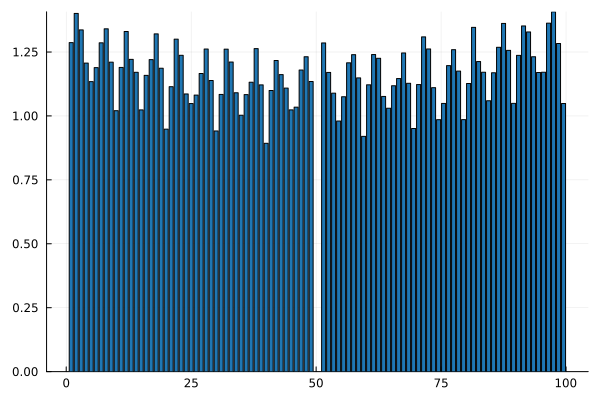

In [81]:
bar(collect(1:49), nts_measured_spectrum50[1:49], c=palette(:tab10), label="")
bar!(collect(51:100), nts_measured_spectrum50[51:99], c=palette(:tab10), label="")

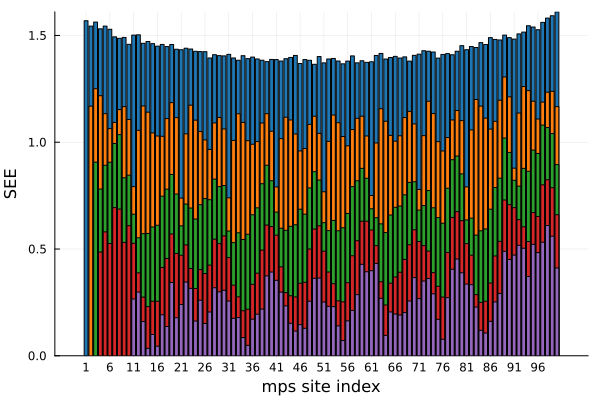

In [70]:
bar(collect(1:100), nts_see_spectrum, c=palette(:tab10)[1], label="",
    xticks=1:5:100, xlabel="mps site index", ylabel="SEE", legend=:none)
bar!(collect(2:100), nts_measured_spectrum1, c=palette(:tab10)[2], label="1 Site")
bar!(collect(3:100), nts_measured_spectrum2, c=palette(:tab10)[3], label="2 Site")
bar!(collect(4:100), nts_measured_spectrum3, c=palette(:tab10)[4], label="3 Site")
#bar!(collect(5:100), nts_measured_spectrum4, c=palette(:tab10)[5], label="")
#bar!(collect(6:100), nts_measured_spectrum5, c=palette(:tab10)[6], label="")
bar!(collect(11:100), nts_measured_spectrum10, c=palette(:tab10)[5], label="10 Site")
#savefig("nts_simple_evolving_see_spect.svg")

In [66]:
cmap = create_colormap(nts_measured_spectrum2)

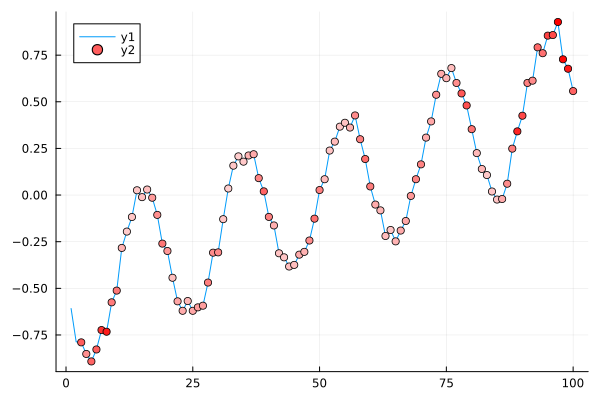

In [69]:
plot(collect(1:100), X_test[4, :])
scatter!(collect(3:100), X_test[4, 3:100], c=cmap)

In [23]:
init_sees = [see(osrdm(mps_80, i)) for i in 1:length(mps_80)]
init_avg_sees = sum(init_sees)/length(init_sees)
avg_sees = [init_avg_sees]
for i in 1:5:100
    println(i)
    mps_measured = measure_mps_with_ts_sample(mps_80, X_test[5, :], mps_80_opts, collect(1:i))
    measured_spect = [see(osrdm(mps_measured, i)) for i in 1:length(mps_measured)]
    see_avg = sum(measured_spect)/length(measured_spect)
    push!(avg_sees, see_avg)
end

1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
96


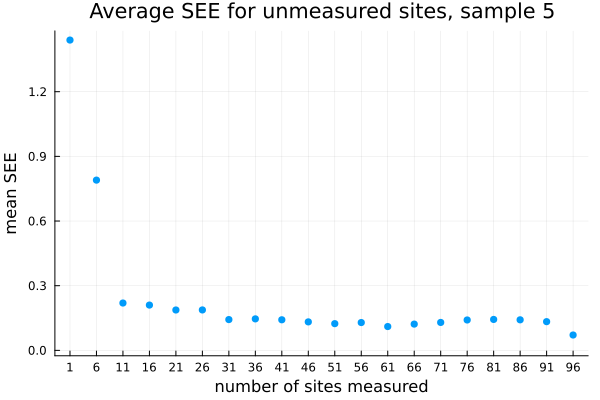

In [87]:
scatter(collect(1:5:100), avg_sees, label="", xlabel="number of sites measured", msw=0, ms=4,
    ylabel="mean SEE", xticks=1:5:100, title="Average SEE for unmeasured sites, sample 5")
#savefig("mean_SEE_unmeasured_nts.svg")